In [ ]:
import os

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

1. Training Set Construction (5 pts)
Construct the training set for the amazon review dataset as instructed and report the following statistics.
Statistics

- the total number of unique words in T
    : 22764 #len(token.word_index)
- the total number of training examples in T  
    : 2000  #len(df)
- the ratio of positive examples to negative examples in T   
    : 1:1   #len(poslist)/len(neglist)
- the average length of document in T   
    : 168.915
- the max length of document in T
    : 3394

In [ ]:
import tensorflow as tf

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# df,tedf = load_data()
def load_data():
    pass
def preprocess(review):
    pass
# df.review = preprocess(df.review)

#### load data

In [ ]:
# in colab
!git clone https://github.com/epsilon-deltta/dataset data
path = './data/amazon-review/'

Cloning into 'data'...
remote: Enumerating objects: 3937, done.
remote: Counting objects: 100% (3937/3937), done.
remote: Compressing objects: 100% (3936/3936), done.
remote: Total 3937 (delta 0), reused 3937 (delta 0), pack-reused 0
Receiving objects: 100% (3937/3937), 23.43 MiB | 24.24 MiB/s, done.


In [ ]:
# in local
path     = './data/'

In [ ]:
def load_data(path='./data/'):
    testdir  = path + 'test/'
    traindir = path + 'train/'

    df = [ pd.DataFrame(columns = ['n','review','target']) for _ in range(2)]

    for i,path in enumerate([traindir,testdir]):
        path = path
        label = 'positive'

        poslist = [ os.path.join(path,label,name) for name in os.listdir(path+label) ]

        label = 'negative' 
        neglist = [ os.path.join(path,label,name) for name in os.listdir(path+label) ]

        sep = os.path.sep

        for fpath in poslist :
            num = fpath.split(sep)[-1]
            with open(fpath,'r') as f :
                content = f.read()

            item = dict(zip(df[i].columns,[num,content,1] ) )
            df[i] = df[i].append(item,ignore_index=True)

        for fpath in neglist :
            num = fpath.split(sep)[-1]
            with open(fpath,'r') as f :
                content = f.read()

            item = dict(zip(df[i].columns,[num,content,0] ) )
            df[i] = df[i].append(item,ignore_index=True)
    return df[0].review,df[0].target,df[1].review,df[1].target

xtr,ytr,xte,yte = load_data(path)

#### count words 

In [ ]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence,Tokenizer

from keras.preprocessing import text

from keras.utils import to_categorical as tc

In [ ]:
token = Tokenizer()             # 토큰화 함수 지정
token.fit_on_texts(xtr)       # 토큰화 함수에 문장 적용

In [ ]:
docs =  token.texts_to_sequences(xtr)

In [ ]:
# the average length of document in T
counts = []
for doc in docs:
    counts.append(len(doc))

In [ ]:
np.mean(counts)

168.915

In [ ]:
import pickle as pk
with open('data/df.pkl','wb') as f:
    pk.dump(df,f)

2. Performance of deep neural network for classification (20 pts)
Suggested hyperparameters: 
	
Data processing: 
- Word embedding dimension: 100
- Word Index: keep the most frequent 10k words

CNN
- Network: Word embedding lookup layer -> 1D CNN layer -> fully connected layer -> output prediction
- Number of filters: 100
- Filter length: 3
- CNN Activation: Relu
- Fully connected layer dimension 100, activation: None (i.e. this layer is linear)

RNN:
- Network: Word embedding lookup layer -> LSTM layer -> fully connected layer(on the hidden state of the last LSTM cell) -> output prediction
- Hidden dimension for LSTM cell: 100
- Activation for LSTM cell: tanh
- Fully connected layer dimension 100, activation: None (i.e. this layer is linear)

{'whiskers': [<matplotlib.lines.Line2D at 0x1b3ff32c860>,
 'caps': [<matplotlib.lines.Line2D at 0x1b3ff32ce10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b3ff32c5f8>],
 'medians': [<matplotlib.lines.Line2D at 0x1b3ff33e400>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b3ff33e6d8>],
 'means': []}

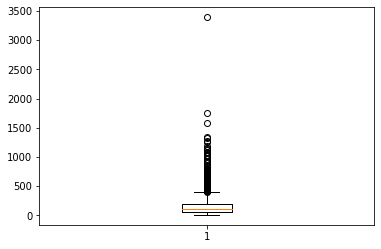

In [ ]:
plt.boxplot(counts)

In [ ]:
pd.DataFrame(counts).describe()

,0
count,2000.000000
mean,168.915000
std,186.859878
min,9.000000
25%,65.000000
50%,117.000000
75%,201.000000
max,3394.000000


In [ ]:
size = 400
total = len(counts)
i = 0 
for x in counts:
    if x < size:
        i += 1
print("including ratio :",i/total)

including ratio : 0.9255


#### tokenizing 

In [ ]:
# - Word Index: keep the most frequent 10k words
vocab_size = 10000
token = Tokenizer(num_words = vocab_size + 1) # 상위 10000개 단어만 사용

token.fit_on_texts(xtr)

In [ ]:
max_len = 400
def preprocess(docs,token,max_len=400):
    docs = token.texts_to_sequences(docs)
    
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    docs = pad_sequences(docs, maxlen=max_len)
    
    return docs

xtr = preprocess(xtr,token)
xte = preprocess(xte,token)

Let me make Embedding Matrix !! 

In [ ]:
# - Word embedding dimension: 100
# vocab_size  = token.num_words # 10000+ 1 
vector_size = 100  #100
vocab_size = 10001

def get_emb_mtr():
    wv = pd.read_csv(path+'all.review.vec.txt',sep=' ',skiprows=1,header=None)

    wv.set_index(0,inplace=True)
    del wv[101]


    embedding_matrix = np.zeros((vocab_size, vector_size))

    def get_vector(word):
        if word in wv.index:
            return wv.loc[word]
        else:
            return None

    num = 0
    word_index = [( i,word) for i,word in token.index_word.items()][:10000]
    # not_used = []
    for i,word in word_index: 
        temp = get_vector(word)
        if temp is not None: 

            embedding_matrix[i] = temp # 해당 단어 위치의 행에 벡터의 값을 저장한다.
    #     else :
    #         not_used.append(word)
    #         num+=1
    return embedding_matrix

embedding_matrix = get_emb_mtr()

#### Models 

In [ ]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Flatten  

from keras.layers import Conv2D,MaxPooling1D,MaxPooling2D ,Conv1D

from keras.layers import Dropout
from keras.layers import Embedding , LSTM

from keras.callbacks import ModelCheckpoint,EarlyStopping

In [ ]:
xtr = xtr.astype('float')
xte = xte.astype('float')
ytr = ytr.astype('float')
yte = yte.astype('float')

In [ ]:

gpus = tf.config.experimental.list_logical_devices(“GPU”)
if len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print(‘\n\nRunning on multiple GPUs ‘, [gpu.name for gpu in gpus])
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
with strategy.scope():
  # cnn w/o pre-emb
  model0 = Sequential()
  e = Embedding(vocab_size, vector_size)
  model0.add(e)
  model0.add(Conv1D(100, 3, padding='valid', activation='relu',strides=1))
  model0.add(Dense(100))
  model0.add(Dense(1,activation='sigmoid'))
  # model1.add(MaxPooling1D(pool_size=4))
  model0.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  # cnn w/ pretrained model
  model1 = Sequential()
  e = Embedding(vocab_size, vector_size, weights=[embedding_matrix], input_length=max_len, trainable=False)
  model1.add(e)
  # model1.add(Flatten())
  # model.add(Dropout(0.5)) 
  model1.add(Conv1D(100, 3, padding='valid', activation='relu',strides=1))
  model1.add(Dense(100))
  model1.add(Dense(1,activation='sigmoid'))
  # model1.add(MaxPooling1D(pool_size=4))
  # model1.add(LSTM(55))
  model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  # lstm model w/ pre-emb
  model2 = Sequential()
  e = Embedding(vocab_size, vector_size, weights=[embedding_matrix], input_length=max_len, trainable=False)
  model2.add(e)
  model2.add(LSTM(100,activation='tanh'))
  # model.add(Dropout(0.5))
  model2.add(Dense(100))
  model2.add(Dense(1,activation='sigmoid'))

  model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  # lstm model w/o pre-emb
  model3 = Sequential()
  e = Embedding(vocab_size, vector_size)
  model3.add(e)
  model3.add(LSTM(100,activation='tanh'))
  # model.add(Dropout(0.5))
  model3.add(Dense(100))
  model3.add(Dense(1,activation='sigmoid'))

  model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  hists = []
  for i in range(4):
      # callback funcs
      import datetime
      log_dir = "logs/model%d/fit/"%i + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
      tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

      from tensorflow import keras
      from time import time
      class timeChecker(keras.callbacks.Callback):
          def on_train_begin(self, logs=None):
              self.durations = []
          def on_epoch_begin(self, epoch, logs=None):
              self.start = time()

          def on_epoch_end(self, epoch, logs=None):
              self.duration = time()-self.start
              self.durations.append(self.duration)

      tchecker = timeChecker()

      from keras.callbacks import ModelCheckpoint,EarlyStopping
      # epoch val_accuracy val_loss

      MODEL_DIR = './model%d/'%i
      if not os.path.exists(MODEL_DIR):
          os.mkdir(MODEL_DIR)

      modelpath="./model%d/{epoch:02d}-{val_loss:.4f}.hdf5"%i
      checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)        


      exec('history = model%d.fit(xtr, ytr, batch_size=100, epochs=300, verbose=1,validation_data=(xte, yte) \
                ,callbacks=[tensorboard_callback,tchecker,checkpointer])'%i )
      history.history['durations']=tchecker.durations
      hists.append(history.history)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/300
20/20 [==============================] - 4s 84ms/step - loss: 0.6935 - acc: 0.5116 - val_loss: 0.6931 - val_acc: 0.5022

Epoch 00001: val_loss improved from inf to 0.69307, saving model to ./model0/01-0.6931.hdf5
Epoch 2/300
20/20 [==============================] - 0s 17ms/step - loss: 0.6909 - acc: 0.5275 - val_loss: 0.6897 - val_acc: 0.5271

Epoch 00002: val_loss improved from 0.69307 to 0.68971, saving model to ./model0/02-0.6897.hdf5
Epoch 3/300
20/20 [==============================] - 0s 16ms/step - loss: 0.6849 - acc: 0.5437 - val_loss: 0.6864 - val_acc: 0.5301

Epoch 00003: val_loss improved from 0.68971 to 0.68639, saving model to ./model0/03-0.6864.hdf5
Epoch 4/300
20/20 [==============================] - 0s 15ms/step - loss: 0.6730 - acc: 0.5558 - val_loss: 0.6894 - val_acc: 0.5304

Epoch 00004: val_loss did not improve from 0.68639
Epoch 5/300
20/20 [============

In [ ]:
# %tensorboard --logdir logs/modeln/fit --port 6006

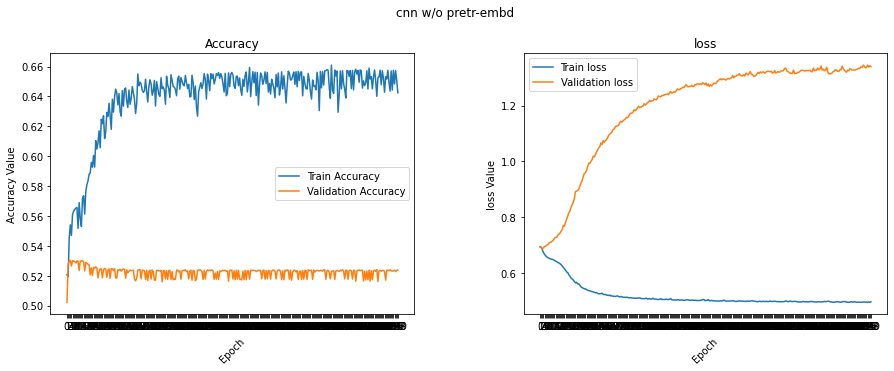

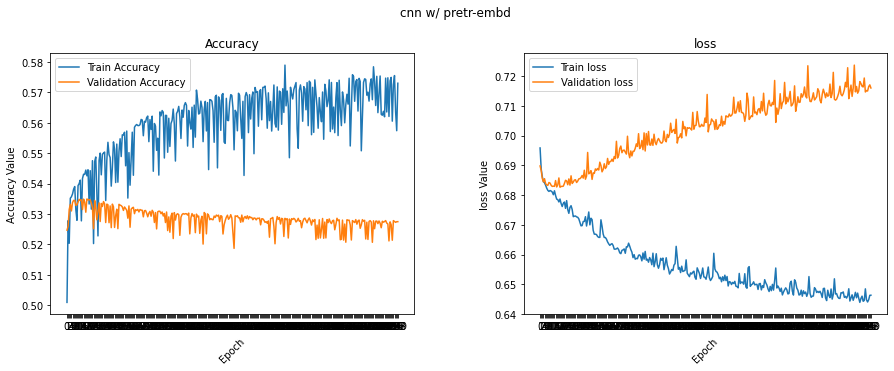

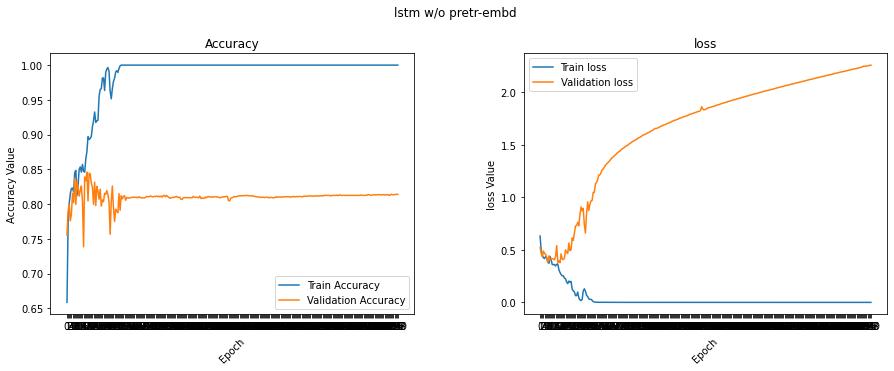

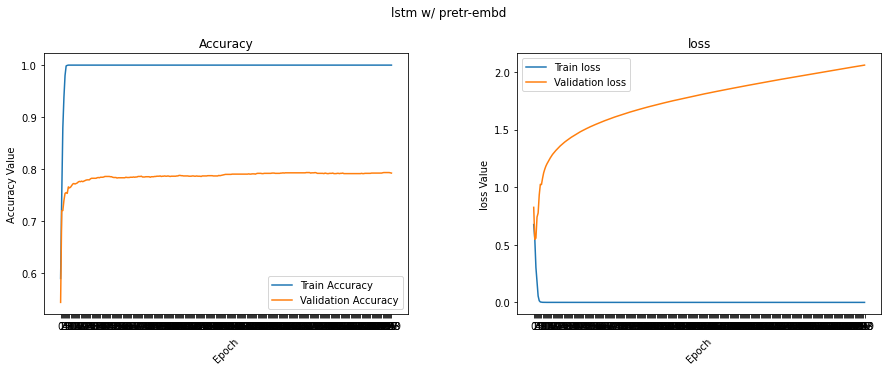

In [ ]:
titles = ['cnn w/o pretr-embd','cnn w/ pretr-embd','lstm w/o pretr-embd','lstm w/ pretr-embd']
for i in range(4):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  t = f.suptitle(titles[i], fontsize=12)
  f.subplots_adjust(top=0.85, wspace=0.3)

  epochs = list(range(len(hists[i]['acc']) )  )
  ax1.plot(epochs, hists[i]['acc'], label='Train Accuracy')
  ax1.plot(epochs, hists[i]['val_acc'], label='Validation Accuracy')
  ax1.set_xticks(epochs)
  ax1.set_ylabel('Accuracy Value')
  ax1.set_xlabel('Epoch',rotation='45')
  ax1.set_title('Accuracy')
  l1 = ax1.legend(loc='best')

  ax2.plot(epochs, hists[i]['loss'], label='Train loss')
  ax2.plot(epochs, hists[i]['val_loss'], label='Validation loss')
  ax2.set_xticks(epochs)
  ax2.set_ylabel('loss Value')
  ax2.set_xlabel('Epoch',rotation='45')
  ax2.set_title('loss')
  l2 = ax2.legend(loc='best')
  f.show()

In [ ]:
hists[0]['val_acc']

[0.5022135376930237,
 0.5270993113517761,
 0.5300503373146057,
 0.5303931832313538,
 0.5265238285064697,
 0.5301117897033691,
 0.5297223329544067,
 0.5295842289924622,
 0.528549075126648,
 0.5298894643783569,
 0.5297512412071228,
 0.5235477089881897,
 0.5299548506736755,
 0.5298429727554321,
 0.5301244258880615,
 0.5294284224510193,
 0.5233115553855896,
 0.5290602445602417,
 0.5283253788948059,
 0.527642011642456,
 0.5274322032928467,
 0.520591676235199,
 0.5254220366477966,
 0.5202324390411377,
 0.5256632566452026,
 0.5250577330589294,
 0.5260201692581177,
 0.5251407623291016,
 0.51861172914505,
 0.5229485630989075,
 0.5245928764343262,
 0.5246947407722473,
 0.5186206102371216,
 0.5239949822425842,
 0.5249271392822266,
 0.5246205925941467,
 0.5189749002456665,
 0.5237122774124146,
 0.5245553255081177,
 0.5182009935379028,
 0.5248103737831116,
 0.5246331095695496,
 0.5234070420265198,
 0.5248317122459412,
 0.5186419486999512,
 0.5185176134109497,
 0.5240565538406372,
 0.523776412010192